# KDE Density Comparison 

Test whether KDE can be used to check the correctness of AHMI reweighting. 

Structure: 

    1) 2D Test
    2) 10D Test
    

In [1]:
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Statistics
using Distributions 
using IntervalSets

using HCubature
using JLD2
using CPUTime
using LaTeXStrings
using SpecialFunctions
using KernelDensity

In [2]:
using BATPar
using KDTree
using BAT

using PyPlot

include("plotting recipes.jl")

corner_plots (generic function with 6 methods)

In [3]:
using Logging
disable_logging(Logging.Info)

LogLevel(1)

# 1. 2D Test:

### 1.2 Define a Gaussian Model:

In [4]:
model = MvNormal([0.;0.], [1. 0.; 0. 3.])

prior = NamedTupleDist(a = model)
posterior = PosteriorDensity(x -> LogDVal(0.0), prior);

In [5]:
iid_samples = bat_sample(NamedTupleDist(a = model,), 10^6).result;

In [6]:
mcmc_samples =  bat_sample(posterior, (10^5, 10), MetropolisHastings()).result;

In [7]:
n_partitions = 10
dims_partition = [1,2]
nsamples_per_subspace = 10^4
nchains_per_subspace = 10

BATPar.make_named_prior(i) = BAT.NamedTupleDist( a =  [[i[j,1]..i[j,2] for j in 1:size(i)[1]]...])
KDTree.evaluate_total_cost(data::Data) = KDTree.cost_f_1(data)

exploration_samples = bat_sample(posterior, (100, 5), MetropolisHastings()).result
data_kdtree = Data(convert(Array{Float64}, flatview(unshaped.(exploration_samples.v))), exploration_samples.weight, exploration_samples.logd)
partition_tree, _ = DefineKDTree(data_kdtree, dims_partition, n_partitions)
extend_tree_bounds!(partition_tree, repeat([-10.], 2), repeat([10.], 2))
subspace_boundaries = extract_par_bounds(partition_tree)
parallel_samples = bat_sample_parallel(x -> LogDVal(logpdf(model, x.a)), subspace_boundaries, (nsamples_per_subspace, nchains_per_subspace),  MetropolisHastings());

┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
Progress: 100%|█

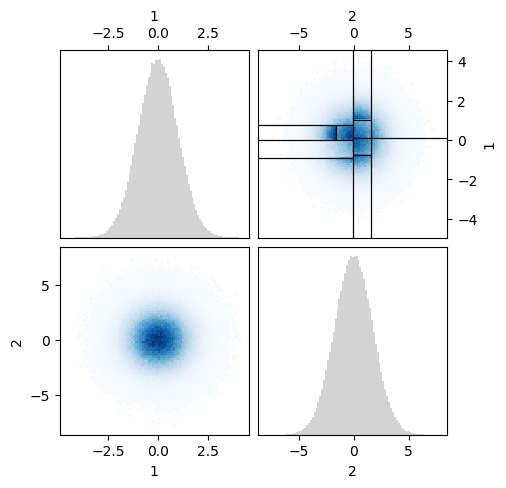

In [8]:
corner_plots(parallel_samples, partition_tree, [1,2,], ["1", "2",], figsize=(5,5))

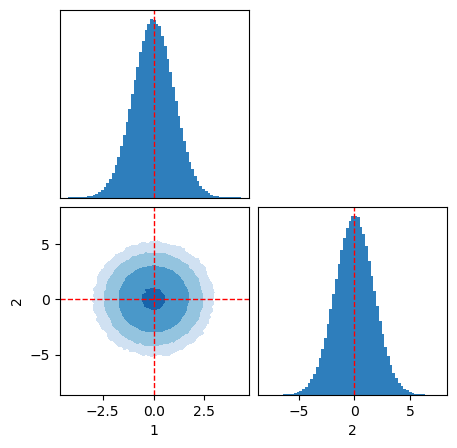

In [9]:
# Samples overview

corner_plots(iid_samples, [1,2,], ["1", "2"], N_bins=70, save_plot=false, figsize=(5,5));

### 1.2 KDE Definition:

In [10]:
kde_iid = kde(collect(flatview(unshaped.(iid_samples.v)))[1:2,:]')
kde_mcmc = kde(collect(flatview(unshaped.(mcmc_samples.v)))[1:2,:]', weights=Weights(mcmc_samples.weight))
kde_parallel = kde(collect(flatview(unshaped.(parallel_samples.samples)))[1:2,:]', weights=Weights(parallel_samples.weights_r));

In [11]:
flat_gridpoints(grids) = vec(collect(Iterators.product(grids...)))

flat_gridpoints (generic function with 1 method)

In [12]:
x_range = range(-3, stop=3, length=60)
y_range = range(-3, stop=3, length=50)

grid = flat_gridpoints((x_range, y_range));

In [13]:
z_truth = [pdf(model, [x,y]) for y in y_range, x in x_range];
z_iid = [pdf(kde_iid, x,y) for y in y_range, x in x_range];
z_mcmc = [pdf(kde_mcmc, x,y) for y in y_range, x in x_range];
z_parallel = [pdf(kde_parallel, x,y) for y in y_range, x in x_range];

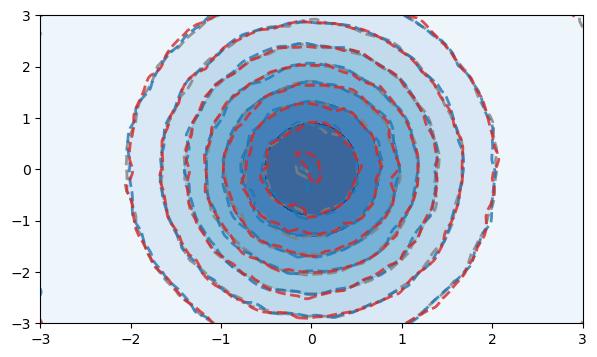

PyObject <matplotlib.contour.QuadContourSet object at 0x165baa550>

In [14]:
levels = collect(range(minimum(z_truth), stop=maximum(z_truth), length=9))


fig, ax = plt.subplots(1,1, figsize=(7,4))
# ax.pcolormesh(x_range, y_range, z,)
ax.contourf(x_range, y_range, z_truth, levels=levels, alpha=0.8, cmap="Blues")
ax.contour(x_range, y_range, z_iid, alpha=0.8, linewidths=2, linestyles="--", levels=levels, colors="gray", label="test")
ax.contour(x_range, y_range, z_mcmc, alpha=0.8, linewidths=2, linestyles="--", levels=levels, colors="C0")
ax.contour(x_range, y_range, z_parallel, alpha=0.8, linewidths=2, linestyles="--", levels=levels, colors="C3")


In [15]:
δ_iid = 100 .* [(z_truth .- z_iid)./ z_truth ...]
δ_mcmc = 100 .* [(z_truth .- z_mcmc)./ z_truth ...]
δ_parallel = 100 .* [(z_truth .- z_parallel)./ z_truth ...];

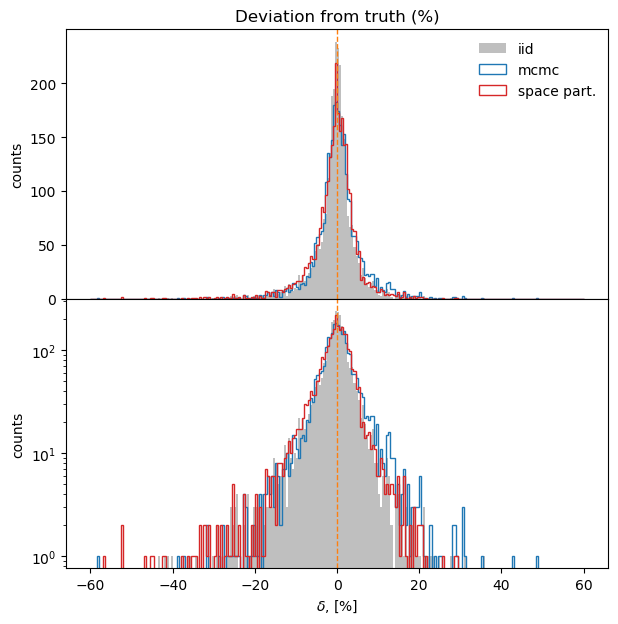

PyObject Text(25.187209472656257, 0.5, 'counts')

In [16]:
δ_bins=collect(-60:0.5:60)

fig, ax = plt.subplots(2,1, figsize=(7,7), sharex=true)
fig.subplots_adjust(wspace=0.00, hspace=0.00)

ax[1].hist(δ_iid, δ_bins, histtype="stepfilled", color = "gray", alpha=0.5,label="iid")
ax[1].hist(δ_mcmc, δ_bins, histtype="step", color = "C0", label="mcmc")
ax[1].hist(δ_parallel, δ_bins, histtype="step",color = "C3", label="space part.")

ax[2].hist(δ_iid, δ_bins, histtype="stepfilled", color = "gray", alpha=0.5,label="iid")
ax[2].hist(δ_mcmc, δ_bins, histtype="step", color = "C0", label="mcmc")
ax[2].hist(δ_parallel, δ_bins, histtype="step",color = "C3", label="space part.")

ax[1].legend(loc="upper right", frameon=false, framealpha=0.8, ncol=1, )

ax[1].axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")
ax[2].axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")
ax[2].set_yscale("log")

ax[1].set_title("Deviation from truth (%)")
ax[2].set_xlabel(L"$\delta$, [%]")
ax[1].set_ylabel("counts")
ax[2].set_ylabel("counts")

In [17]:
δ_mcmc_iid = 100 .* [(z_iid .- z_mcmc)./ z_iid ...]
δ_parallel_iid = 100 .* [(z_iid .- z_parallel)./ z_iid ...];

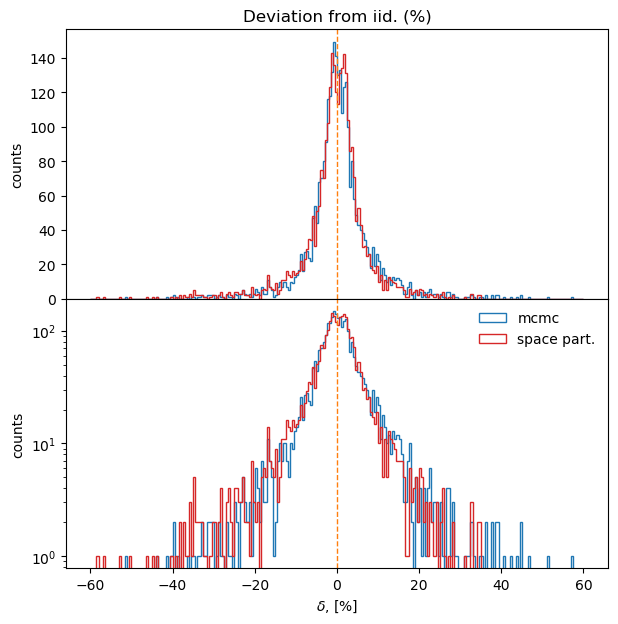

PyObject Text(24.000000000000007, 0.5, 'counts')

In [18]:
δ_bins=collect(-60:0.5:60)

fig, ax = plt.subplots(2,1, figsize=(7,7), sharex=true)
fig.subplots_adjust(wspace=0.00, hspace=0.00)

ax[1].hist(δ_mcmc_iid, δ_bins, histtype="step", color = "C0", label="mcmc")
ax[1].hist(δ_parallel_iid, δ_bins, histtype="step", color = "C3", label="space part.")
ax[1].axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")

ax[2].hist(δ_mcmc_iid, δ_bins, histtype="step", color = "C0", label="mcmc")
ax[2].hist(δ_parallel_iid, δ_bins, histtype="step", color = "C3", label="space part.")
ax[2].legend(loc="upper right", frameon=false, framealpha=0.8, ncol=1, )
ax[2].axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")
ax[2].set_yscale("log")

ax[1].set_title("Deviation from iid. (%)")
ax[2].set_xlabel(L"$\delta$, [%]")
ax[2].set_ylabel("counts")
ax[1].set_ylabel("counts")

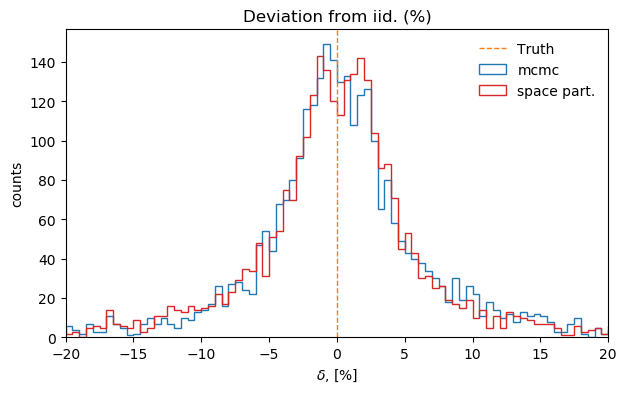

(-20, 20)

In [168]:
δ_bins=collect(-60:0.5:60)

fig, ax = plt.subplots(1,1, figsize=(7,4),)
fig.subplots_adjust(wspace=0.00, hspace=0.00)

ax.hist(δ_mcmc_iid, δ_bins, histtype="step", color = "C0", label="mcmc")
ax.hist(δ_parallel_iid, δ_bins, histtype="step", color = "C3", label="space part.")
ax.axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")
ax.legend(loc="upper right", frameon=false, framealpha=0.8, ncol=1, )
ax.set_title("Deviation from iid. (%)")
ax.set_xlabel(L"$\delta$, [%]")
ax.set_ylabel("counts")
ax.set_xlim(-20, 20)

# 10D Test: 

In [19]:
JLD2.@load "MixtureModels/mixture-1.jld" means cov_m n_clusters

model_2 = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters]);

In [20]:
m2_prior =  NamedTupleDist(a = model_2,)
m2_posterior = PosteriorDensity(x -> LogDVal(0.0), m2_prior);

In [21]:
m2_iid_samples = bat_sample(m2_prior, 10^7).result;

In [22]:
m2_mcmc_samples =  bat_sample(m2_posterior, (10^6, 10), MetropolisHastings()).result;

In [23]:
n_partitions_m2 = 20
N_m2 = 6
dims_partition_m2 = [1,2,3,4,5,6]
nsamples_per_subspace_m2 = 10^5
nchains_per_subspace_m2 = 5

BATPar.make_named_prior(i) = BAT.NamedTupleDist( a =  [[i[j,1]..i[j,2] for j in 1:size(i)[1]]...])
KDTree.evaluate_total_cost(data::Data) = KDTree.cost_f_1(data)

exploration_samples_m2 = bat_sample(m2_prior, 10^3).result;
data_kdtree_m2 = Data(convert(Array{Float64}, flatview(unshaped.(exploration_samples_m2.v))), exploration_samples_m2.weight, exploration_samples_m2.logd)
partition_tree_m2, _ = DefineKDTree(data_kdtree_m2, dims_partition_m2, n_partitions_m2)
extend_tree_bounds!(partition_tree_m2, repeat([-100.], N_m2), repeat([100.], N_m2))
subspace_boundaries_m2 = extract_par_bounds(partition_tree_m2)
parallel_samples_m2 = bat_sample_parallel(x -> LogDVal(logpdf(model_2, x.a)), subspace_boundaries_m2, (nsamples_per_subspace_m2, nchains_per_subspace_m2),  MetropolisHastings());

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 

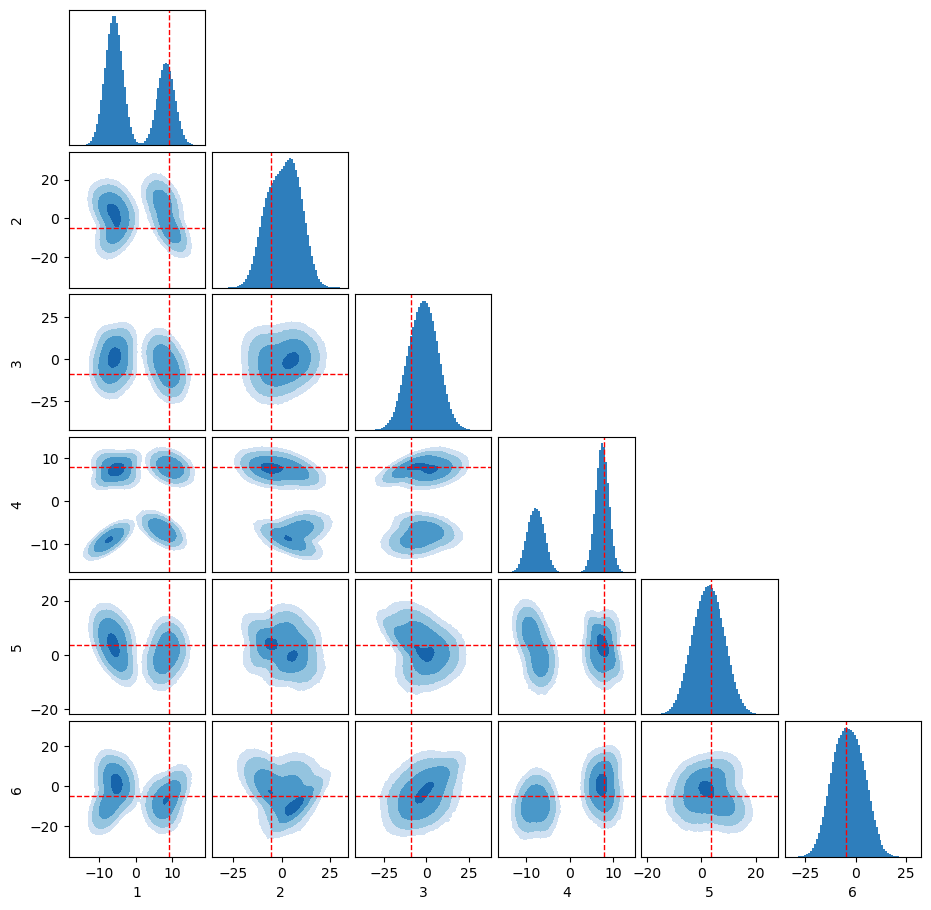

In [31]:
corner_plots(m2_mcmc_samples, [1,2,3,4,5,6], ["1", "2", "3", "4", "5","6"], N_bins=70, save_plot=false);

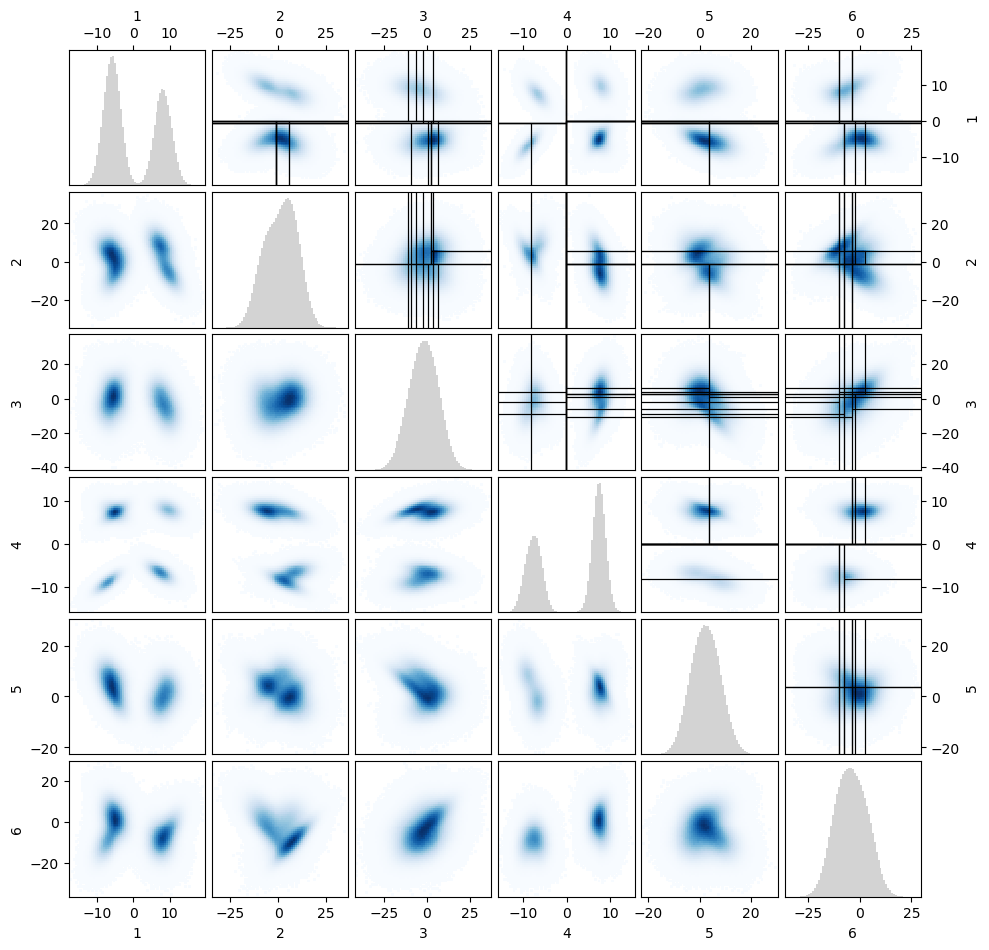

In [24]:
corner_plots(parallel_samples_m2, partition_tree_m2, [1,2,3,4,5,6], ["1", "2", "3", "4", "5","6"], N_bins=70, save_plot=false)

In [25]:
max_smpl = maximum(collect(flatview(unshaped.(m2_iid_samples.v))))
min_smpl = minimum(collect(flatview(unshaped.(m2_iid_samples.v))));

@show max_smpl, min_smpl;

(max_smpl, min_smpl) = (37.89158f0, -43.306324f0)


In [164]:
# Example 

kde_iid_example = kde(flatview(unshaped.(m2_iid_samples.v))[1:2,:]', weights=m2_iid_samples.weight)
kde_mcmc_example = kde(flatview(unshaped.(m2_mcmc_samples.v))[1:2,:]', weights=m2_mcmc_samples.weight)
kde_par_example = kde(flatview(unshaped.(parallel_samples_m2.samples))[1:2,:]', weights=parallel_samples_m2.weights_r)

range_example = collect(range(-30, stop=30, length=60))

z_iid = [pdf(kde_iid_example, x,y) for y in range_example, x in range_example]
z_mcmc = [pdf(kde_mcmc_example, x,y) for y in range_example, x in range_example]
z_parallel = [pdf(kde_par_example, x,y) for y in range_example, x in range_example];


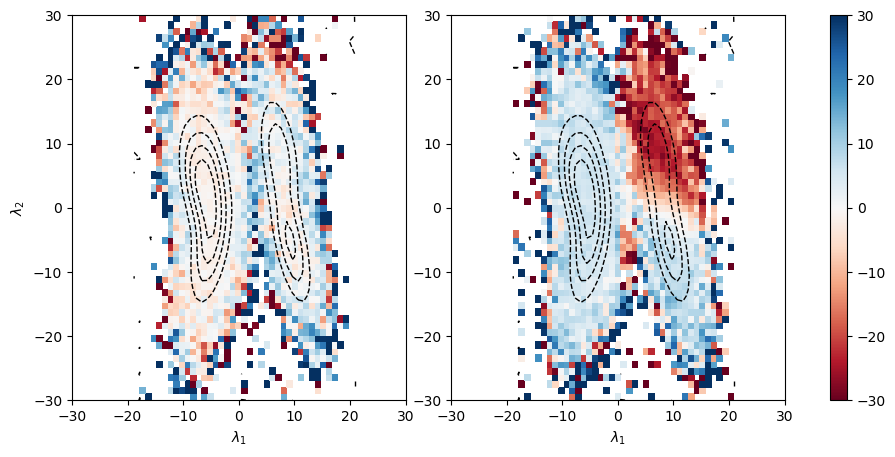

PyObject Text(0.5, 27.4, '$\\lambda_1$')

In [165]:
fig, (ax, ax2, cax) = plt.subplots(ncols=3, figsize=(10,5), gridspec_kw=Dict(["width_ratios"=>[1,1, 0.05]]))
fig.subplots_adjust(wspace=0.2, hspace=0.1)

cs = ax.pcolormesh(range_example, range_example, replace(x-> abs(x) > 50 ? NaN : x ,100. .* (z_iid .- z_mcmc) ./ z_iid), vmin=-30, vmax=30, cmap="RdBu")
ax2.pcolormesh(range_example, range_example, replace(x-> abs(x) > 50 ? NaN : x ,100. .* (z_iid .- z_parallel) ./ z_iid), vmin=-30, vmax=30, cmap="RdBu")

ax.contour(range_example, range_example, replace(x-> x==0 ? NaN : x , z_iid), alpha=1, levels=4, linewidths=1, linestyles="--", colors="black", label="test")
ax2.contour(range_example, range_example, replace(x-> x==0 ? NaN : x , z_iid), alpha=1, levels=4, linewidths=1, linestyles="--", colors="black", label="test")

fig.colorbar(cs, cax=cax)
ax.set_ylabel(L"\lambda_2")
ax.set_xlabel(L"\lambda_1")
ax2.set_xlabel(L"\lambda_1")

In [37]:
function get_kde_values(samples, sample_weights; min=-50, max=50, N=50)
    
    kdes_vals = Float64[]
    
    for i in 2:N_m2, j in 1:(i-1)
        
        x_tmp = samples[j,:]
        y_tmp = samples[i,:]

        w = sample_weights

        kde_tmp = kde((x_tmp,y_tmp), weights=sample_weights)

        x_range = range(min, stop=max, length=N)
        y_range = range(min, stop=max, length=N)
        
        z_tmp = [pdf(kde_tmp, x,y) for y in y_range, x in x_range];
        append!(kdes_vals, [z_tmp...])
        
    end
    
    return kdes_vals
end

get_kde_values (generic function with 1 method)

In [38]:
m2_par_vals = get_kde_values(collect(flatview(unshaped.(parallel_samples_m2.samples))), parallel_samples_m2.weights_r);
m2_iid_vals = get_kde_values(collect(flatview(unshaped.(m2_iid_samples.v))), m2_iid_samples.weight)
m2_mcmc_vals = get_kde_values(collect(flatview(unshaped.(m2_mcmc_samples.v))), m2_mcmc_samples.weight);

In [39]:
m2_δ_mcmc = 100. .* (m2_iid_vals .- m2_mcmc_vals) ./ m2_iid_vals
m2_δ_par = 100. .* (m2_iid_vals .- m2_par_vals) ./ m2_iid_vals;

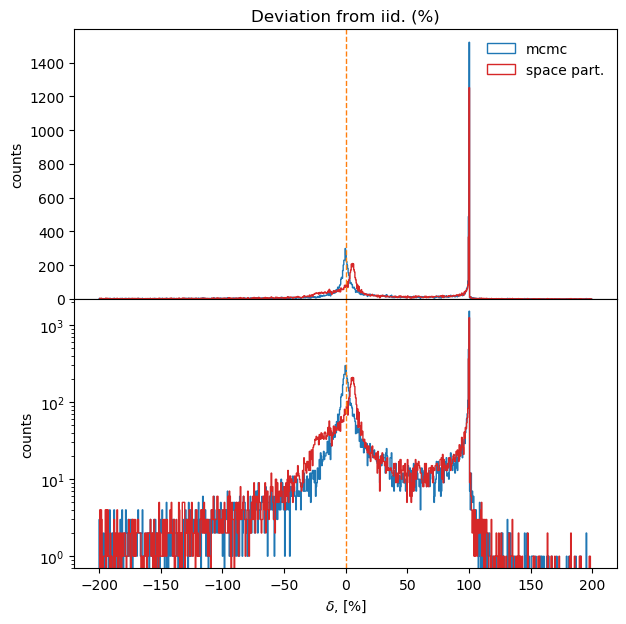

PyObject Text(33.81220947265625, 0.5, 'counts')

In [50]:
δ_bins=collect(-200:0.5:200)

fig, ax = plt.subplots(2,1, figsize=(7,7), sharex=true)
fig.subplots_adjust(wspace=0.00, hspace=0.00)

ax[1].hist(m2_δ_mcmc, δ_bins, histtype="step", color = "C0", label="mcmc")
ax[1].hist(m2_δ_par, δ_bins, histtype="step", color = "C3", label="space part.")

ax[2].hist(m2_δ_mcmc, δ_bins, histtype="step", color = "C0", label="mcmc")
ax[2].hist(m2_δ_par, δ_bins, histtype="step", color = "C3", label="space part.")

ax[1].legend(loc="upper right", frameon=false, framealpha=0.8, ncol=1, )

ax[1].axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")
ax[2].axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")
ax[2].set_yscale("log")

ax[1].set_title("Deviation from iid. (%)")
ax[2].set_xlabel(L"$\delta$, [%]")
ax[1].set_ylabel("counts")
ax[2].set_ylabel("counts")

# ax[1].set_xlim(-10, 10)

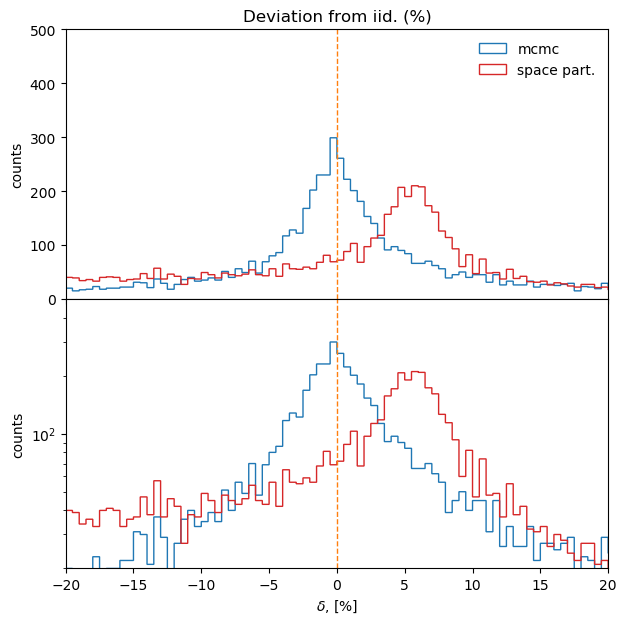

(20, 500)

In [51]:
δ_bins=collect(-200:0.5:200)

fig, ax = plt.subplots(2,1, figsize=(7,7), sharex=true)
fig.subplots_adjust(wspace=0.00, hspace=0.00)

ax[1].hist(m2_δ_mcmc, δ_bins, histtype="step", color = "C0", label="mcmc")
ax[1].hist(m2_δ_par, δ_bins, histtype="step", color = "C3", label="space part.")

ax[2].hist(m2_δ_mcmc, δ_bins, histtype="step", color = "C0", label="mcmc")
ax[2].hist(m2_δ_par, δ_bins, histtype="step", color = "C3", label="space part.")

ax[1].legend(loc="upper right", frameon=false, framealpha=0.8, ncol=1, )

ax[1].axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")
ax[2].axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")
ax[2].set_yscale("log")

ax[1].set_title("Deviation from iid. (%)")
ax[2].set_xlabel(L"$\delta$, [%]")
ax[1].set_ylabel("counts")
ax[2].set_ylabel("counts")

ax[1].set_xlim(-20, 20)
ax[1].set_ylim(0, 500)
ax[2].set_ylim(20, 500)

In [52]:
m2_δ_mcmc_diff = m2_iid_vals .- m2_mcmc_vals 
m2_δ_par_diff = m2_iid_vals .- m2_par_vals;

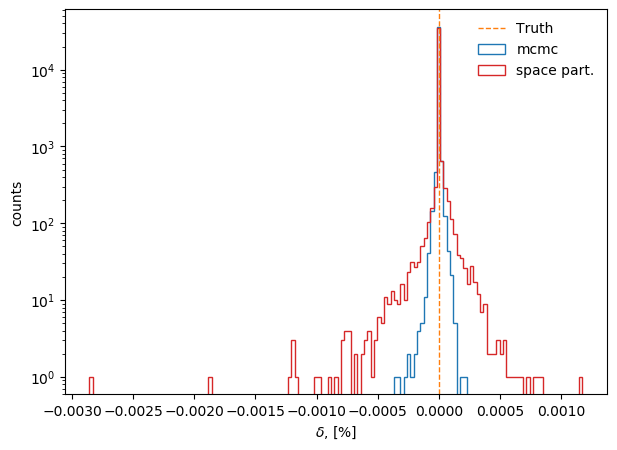

PyObject <matplotlib.legend.Legend object at 0x1aa29e210>

In [53]:
min_tmp  = minimum([minimum(m2_δ_mcmc_diff), minimum(m2_δ_par_diff)])
max_tmp  = maximum([maximum(m2_δ_mcmc_diff), maximum(m2_δ_par_diff)])

δ_bins=collect(range(min_tmp, stop=max_tmp, length=150))

fig, ax = plt.subplots(1,1, figsize=(7,5), sharex=true)
fig.subplots_adjust(wspace=0.00, hspace=0.00)

ax.hist(m2_δ_mcmc_diff, δ_bins, histtype="step", color = "C0", label="mcmc")
ax.hist(m2_δ_par_diff, δ_bins, histtype="step", color = "C3", label="space part.")

ax.axvline(0, c="C1", label="Truth", alpha=1, lw=1, ls="--")
ax.set_yscale("log")


ax.set_xlabel(L"$\delta$, [%]")
ax.set_ylabel("counts")

ax.legend(loc="upper right", frameon=false, framealpha=0.8, ncol=1, )

# ax[1].set_xlim(-10, 10)